# Assignment 2

For this assignment, I opted to use python for the following data analysis, allowing for a more robust and flexible approach.
    

In [1]:
## IMPORTS ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn 

data = pd.read_csv(r"C:\Users\perso\Desktop\Tulane U\Senior Year\Semester 7\EENS-4081\Assignment 2\Carbon stock and sequestration assessment-SISON.csv", header= 2)
data.head(5)

,Group members,Tree #,Species,Diameter (cm),Condition\n Excellent/good/fair/poor/dead,Sunlight\n Full sun/partial sun/full shade,Other notes
0,Mikey/Rayna,1,Crape Myrtle,57.4,good,partial sun,NaN
1,Mikey/Rayna,2,Green Ash,90.2,excellent,full sun,NaN
2,Mikey/Rayna,3,Cyprus,44.3,excellent,partial sun,NaN
3,Mikey/Rayna,4,Cyprus,50.4,excellent,full sun,NaN
4,Mikey/Rayna,5,Cyprus,55.1,good,partial sun,NaN


## Consolidated Species 

Since, due to human intervention, there are many species names that are not uniform in text format. Thus, we can do a simple comparison to reformat each species to the correct format. This allows us to group and compare species much better than previously. 

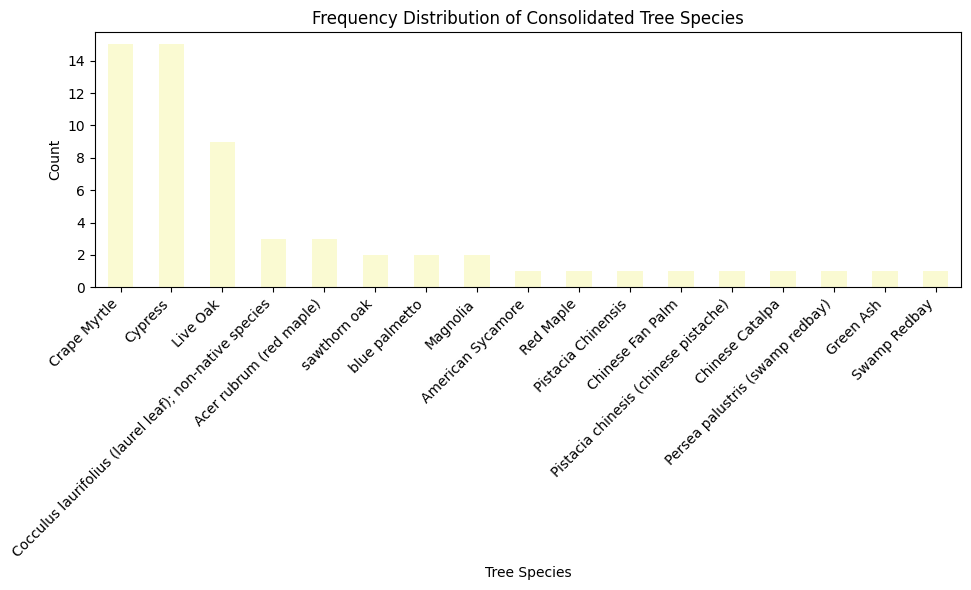

In [22]:
consolidated_data = data

# Unify the text formatting for species names.
consolidated_data['Species'] = data['Species'].str.replace('cyprus', 'cypress', case=False)
consolidated_data['Species'] = data['Species'].apply(lambda x: 'Cypress' if 'cypress' in x.lower() else x)
consolidated_data['Species'] = data['Species'].apply(lambda x: 'Live Oak' if 'live oak' in x.lower() else x)
consolidated_data['Species'] = data['Species'].apply(lambda x: 'Magnolia' if 'magnolia' in x.lower() else x)
consolidated_data['Species'] = data['Species'].apply(lambda x: 'Crape Myrtle' if 'crape myrtle' in x.lower() else x)


# Counting the frequency of each consolidated tree species
consolidated_species_counts = data['Species'].value_counts()

# Plotting the frequency of each consolidated species
plt.figure(figsize=(10, 6))
consolidated_species_counts.plot(kind='bar', color='lightgoldenrodyellow')
plt.title('Frequency Distribution of Consolidated Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [23]:
# Convert the 'Diameter (cm)' column to a numeric type
consolidated_data['Diameter (cm)'] = pd.to_numeric(data['Diameter (cm)'], errors='coerce')

# Grouping by species and calculating the average diameter
species_diameter_avg = consolidated_data.groupby('Species')['Diameter (cm)'].mean().sort_values(ascending=False)

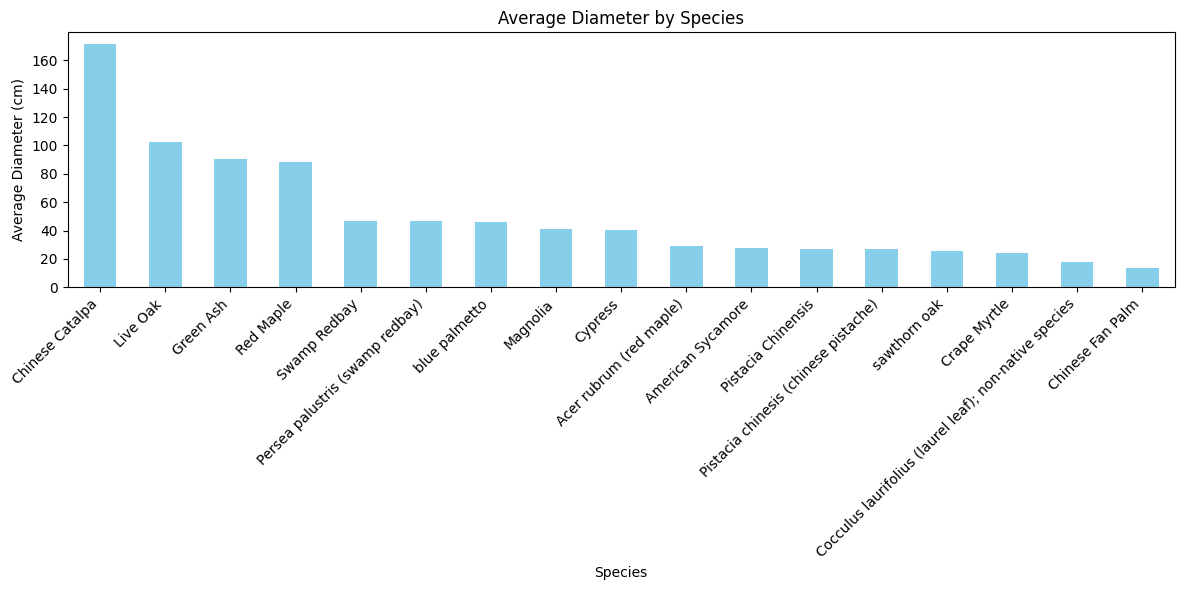

In [24]:
# Plotting the average diameter by species
plt.figure(figsize=(12, 6))
species_diameter_avg.plot(kind='bar', color='skyblue')
plt.title('Average Diameter by Species')
plt.xlabel('Species')
plt.ylabel('Average Diameter (cm)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Allometry 

 As described by Jenkins et al. (2004), there exist many different allometric equations for the estimation of dry biomass. However, for certain species, there are limitations on accurate estimation due to a number of factors. Constraints on the DBH range, availablility of species equations, and uncertainties are all cited as important factors. For the purposes of this analysis, some assumptions or liberties have been made in order to ensure plausible calculations. 


Jenkins et al. (2004)
Equation form description Equation form ID
1. log10 biomass = a + b * (log10(dia^c)) 
2. ln biomass = a + b * dia + c * (ln(dia^d)) 
3. ln biomass = a + b * ln(dia) + c * (d + (e * ln(dia))) 
4. biomass = a + b * dia + c * (dia ^ d) 
5. biomass = a + (b * dia) + c * (dia ^ 2) + d * (dia ^ 3) 
6. biomass = a * (exp(b + (c * ln(dia)) + (d * dia))) 
7. biomass = a + ((b * (dia ^ c))/((dia ^ c) + d)) 
8. log100 biomass = a + (b * log10(dia)) 
9. ln biomass = ln(a) + (b * ln(dia)) 

In [76]:
# Set & create Biomass column
consolidated_data["Biomass (Kg) General"] = np.nan
consolidated_data["Biomass (Kg) eq1"] = np.nan
consolidated_data["Biomass (Kg) eq2"] = np.nan
consolidated_data["Biomass (Kg) eq3"] = np.nan
consolidated_data["Biomass (Kg) eq4"] = np.nan
consolidated_data["Biomass (Kg) eq5"] = np.nan
consolidated_data["Biomass (Kg) eq6"] = np.nan
consolidated_data["Biomass (Kg) eq7"] = np.nan
consolidated_data["Biomass (Kg) eq8"] = np.nan
consolidated_data["Biomass (Kg) eq9"] = np.nan


In [77]:
# Allometric equations
import math

Jenkins_allometric_equations = { 
                         "eq1" : lambda dbh, a, b, c: 10**(a + b*(math.log10(dbh**c))),
                         "eq2" : lambda dbh, a, b, c, d: math.exp(a + b*dbh + c*(math.log(dbh**d))),
                         "eq3" : lambda dbh, a, b, c, d, e: math.exp(a + b*math.log(dbh) + c*(d + e*math.log(dbh))),
                         "eq4" : lambda dbh, a, b, c, d: a + b*dbh + c*(dbh**d),
                         "eq5" : lambda dbh, a, b, c, d: a + b*dbh + c*(dbh**2) + d*(dbh**3) ,
                         "eq6" : lambda dbh, a, b, c: a*(math.exp(b+(c*math.log()))),
                         "eq7" : lambda dbh, a, b, c, d: a+((b*(dbh**c))/(dbh**c)+d),
                         "eq8" : lambda dbh, a, b: 100**(a + (b * math.log10(dbh))),
                         "eq9" : lambda dbh, a, b, : math.exp(math.log(a) + (b*math.log(dbh))),
                         "general" : lambda dbh, beta0, beta1: math.exp(beta0 + beta1*math.log(dbh)),
                        }


### Live Oak Allometry Model

As described by Jenkins et al. (2004) and independent database and Google Scholar search results, there does not exist exact allometric equations for, specifically, Live Oaks, *Quercus virginiana*. Jenkins et al. (2004) does describe a methodology for estimating species without exact allometric equations. They specifically mention Live Oaks as one of these species. Unfortunately, the DBH range for the general equation provided with hardwoods parameters is lower than most of the Live Oak DBH measurements that we obtained. However, the paper does specify the Northern Red Oak as the sourcee for bark specific gravity estimations for the *genus Quercus*. So, for this and further estimates, I will use the reference species as a secondary plausible estimate for biomass. So, both the general equation for hardwoods will be used, as well as the specific equation for the Northern Red Oak.

#### General Hardwood Estimation

In [78]:
# General Equation
beta0_LO = -2.0127
beta1_LO = 2.4342
liveOaks = consolidated_data[consolidated_data["Species"] == "Live Oak"]
consolidated_data.loc[consolidated_data["Species"] == "Live Oak","Biomass (Kg) General"] = liveOaks["Diameter (cm)"].apply(Jenkins_allometric_equations["general"], args=(beta0_LO, beta1_LO))


#### Northern Red Oak Estimation

Using the Northern Red Oak Estimation for the whole aboveground biomass, we can use equations 1 and 2. Again, similar to the general equation, our DBH measurements are outside of the range specified.

In [84]:
# Equation 1
a = -1.259		
b = 2.644
c = 1

consolidated_data.loc[consolidated_data["Species"] == "Live Oak","Biomass (Kg) eq1"] = liveOaks["Diameter (cm)"].apply(Jenkins_allometric_equations["eq1"], args=(a, b, c))


In [86]:
# Equation 2 
a = 4.9967
b = 0
c = 2.3944
d = 1

consolidated_data.loc[consolidated_data["Species"] == "Live Oak","Biomass (Kg) eq2"] = liveOaks["Diameter (cm)"].apply(Jenkins_allometric_equations["eq2"], args=(a, b, c, d)) / 1000
consolidated_data[consolidated_data["Species"] == "Live Oak"]

,Group members,Tree #,Species,Diameter (cm),Condition\n Excellent/good/fair/poor/dead,Sunlight\n Full sun/partial sun/full shade,Other notes,Biomass (Kg) General,Biomass (Kg) eq1,Biomass (Kg) eq2,Biomass (Kg) eq3,Biomass (Kg) eq4,Biomass (Kg) eq5,Biomass (Kg) eq6,Biomass (Kg) eq7,Biomass (Kg) eq8,Biomass (Kg) eq9
12,Mikey/Rayna,13,Live Oak,112.1,excellent,full sun,NaN,13033.032506,14459.631982,11956.798668,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Zoë/Guandong,20,Live Oak,69.9,Excellent,Full sun,NaN,4127.830327,4147.607515,3858.827700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Zoë/Guandong,21,Live Oak,41.4,Excellent,Full sun,NaN,1153.447220,1038.362277,1100.993752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Zoë/Guandong,22,Live Oak,119.8,Excellent,Full sun,NaN,15320.575620,17236.132616,14018.328823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,Melinda/Asif,28,Live Oak,151.5,Fair,Partial sun,NaN,27130.383149,32063.505444,24593.438074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,Extracted from Google Maps-- Nico/Will,32,Live Oak,118.1,excellent,full sun,NaN,14796.745259,16596.966955,13546.727430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,Extracted from Google Maps-- Nico/Will,33,Live Oak,52.2,excellent,full sun,NaN,2027.911671,1916.552895,1917.915593,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,Extracted from Google Maps-- Nico/Will,34,Live Oak,105.1,good,partial sun,NaN,11139.888081,12193.196737,10246.246057,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,Extracted from Google Maps-- Nico/Will,50,Live Oak,151.5,Fair,Full Sun,NaN,27130.383149,32063.505444,24593.438074,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Bald Cypress Allometry Model
Similar to the Live Oak, the Bald Cypress does not have species specific equations. Instead, we can use the generalized equations for softwoods with Cedars & Larch parameters. We also will use the reference species, the Northern White Cedar. 

In [88]:
# General Equation
beta0_BC = -2.0336 
beta1_BC = 2.2592
baldCypress = consolidated_data[consolidated_data["Species"] == "Cypress"]
consolidated_data.loc[consolidated_data["Species"] == "Cypress","Biomass (Kg) General"] = baldCypress["Diameter (cm)"].apply(Jenkins_allometric_equations["general"], args=(beta0_BC, beta1_BC))


#### Northern White Cedar Estimation
The equation provided is only applicable up to 30cm, explaining some of the larger differences at the higher end of the DBH range.

In [114]:
# Equation 4
a, b, c, d = 0,	0,	0.1148,	2.1439

baldCypress = consolidated_data[consolidated_data["Species"] == "Cypress"]
consolidated_data.loc[consolidated_data["Species"] == "Cypress","Biomass (Kg) eq4"] = baldCypress["Diameter (cm)"].apply(Jenkins_allometric_equations["eq4"], args=(a, b, c, d))


In [116]:
consolidated_data[consolidated_data["Species"] == "Cypress"]

,Group members,Tree #,Species,Diameter (cm),Condition\n Excellent/good/fair/poor/dead,Sunlight\n Full sun/partial sun/full shade,Other notes,Biomass (Kg) General,Biomass (Kg) eq1,Biomass (Kg) eq2,Biomass (Kg) eq3,Biomass (Kg) eq4,Biomass (Kg) eq5,Biomass (Kg) eq6,Biomass (Kg) eq7,Biomass (Kg) eq8,Biomass (Kg) eq9
2,Mikey/Rayna,3,Cypress,44.3,excellent,partial sun,NaN,686.078863,NaN,NaN,NaN,388.746809,NaN,NaN,NaN,NaN,NaN
3,Mikey/Rayna,4,Cypress,50.4,excellent,full sun,NaN,918.226473,NaN,NaN,NaN,512.604855,NaN,NaN,NaN,NaN,NaN
4,Mikey/Rayna,5,Cypress,55.1,good,partial sun,NaN,1123.125877,NaN,NaN,NaN,620.578608,NaN,NaN,NaN,NaN,NaN
5,Mikey/Rayna,6,Cypress,4.9,excellent,full sun,NaN,4.743618,NaN,NaN,NaN,3.464601,NaN,NaN,NaN,NaN,NaN
30,Zoë/Guandong,23,Cypress,45.9,Excellent,Full sun,NaN,743.337360,NaN,NaN,NaN,419.471158,NaN,NaN,NaN,NaN,NaN
